<a href="https://colab.research.google.com/github/Sudar278/Email_Campaign_Effectiveness_Prediction-Classification-/blob/main/Email_Campaign_Effectiveness_Prediction(Classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Title: Email Campaign Effectiveness Prediction


## Problem Description
Most of the small to medium business owners are making effective use of Gmail-based e-mail marketing strategies for offline targeting of converting their prospective customers into leads so that they stay with them in business.

The main objective is to create a machine learning model to characterize the mail and track the mail that is ignored; read; acknowledged by the reader.


### Data Columns Explanation






Email_ID : E-mail ID of recipients.

Email_Type : 2 different e-mail types: 1 and 2.

Subject_Hotness_Score : Measures the strength and effectiveness of mail subject.

Email_Source_Type : 2 Types of different e-mail source types: 1 and 2.

Customer_Location : Differentiates between 7 different e-mail customer locations: A, B, C, D, E, F and G.

Email_Campaign_Type : 3 different types of e-mail campaign types: 1, 2 and 3.

Total_Past_Communications : Number of previous communications from the same source. The number of communications happened 

Time_Email_sent_Category : Differentiates between 3 different time of day (the mail was sent) category: 1, 2 and 3.

Word_Count : Number of words in the mail.

Total_Links : Number of links in the mail.

Total_Images : Number of images in the mail.

Email_Status : Differentiates between 3 different e-mail statuses: 1, 2 and 3, representing ignored, read & acknowledged respectively. This is the target variable.


#### Task
Analysing the data on e-mail marketing campaign and data cleaning, EDA, Feature Engineering and to build classification machine
learning model to predict the mail that is ignored, read or acknowledged by the reader.

# Importing Libraries and Defining Functions 

In [2]:
# Importing Libraries
import warnings
warnings.filterwarnings("ignore")

import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

import pickle

In [3]:
# Defining a function to calucate the count and percentage of NA values
def NA_count_percentage(dataframe):
  num=0
  for column in dataframe.columns:
    count=dataframe[column].isnull().sum()
    percentage=count/dataframe.shape[0]*100
    if percentage > 0:
      num=+1
      print(f'{column} : {count}, {round(percentage,2)}%')
  if num==0:
   print('No Missing Values')


In [4]:
# Defining a function to generate a density plot
def dense_plot(dataframe,coloumn_name):
  plt.figure(figsize=(8,6))
  sns.distplot(dataframe[coloumn_name])
  plt.show()

In [5]:
# Defining a function to generate a box plot
def box_plot(dataframe,x,y=None):
  sns.set_theme(rc={'figure.figsize':(8,4)})
  if y != None:
    sns.boxplot(data=dataframe,x=dataframe[x],y=dataframe[y],orient='h')
  else:
    sns.boxplot(data=dataframe,x=dataframe[x],y=None,orient='h')
  plt.show()

In [6]:
# Defining a function to generate upper and lower outlier boundaryboundary

def up_low_bound(dataframe,coloumn_name):
  percntile_25=np.nanpercentile(dataframe[coloumn_name],25)
  percntile_75=np.nanpercentile(dataframe[coloumn_name],75)
  iqr=(percntile_75-percntile_25)
  upper_bound=(percntile_75+1.5*iqr)
  lower_bound=(percntile_25-1.5*iqr)
  return (upper_bound,lower_bound)
  

# Defining a function to generate outlier count and percentage
def out_count_percen(dataframe,coloumn_name):
  upper_bound,lower_bound=up_low_bound(dataframe,coloumn_name)
  count=0
  for value in dataframe[coloumn_name]:
    if value > upper_bound or value < lower_bound:
      count+=1
  percent=round(count/dataframe.shape[0]*100,2)

  return (count,percent)

In [7]:
# Defining a function to generate a Count Plot
def count_plot(dataframe,coloumn_name):
  plt.figure(figsize=(8,6))
  sns.countplot(data=dataframe,x=coloumn_name)
  plt.show()

In [8]:
# Defining a function to generate a Distribution plot for all features in a Dataframe
def dist_plot_all_features(dataframe):
 coloumn_names=dataframe.describe().columns.tolist()
 plt.figure(figsize=(30,60))
 for i in enumerate(coloumn_names):
   plt.subplot((dataframe.shape[1]),3,i[0]+1)
   sns.distplot(dataframe[(i[1])])

# Data Loading

In [9]:
# Loading data from google drive and creating a dataframe df 
from google.colab import drive
drive.mount('/content/drive')
df=pd.read_csv('/content/drive/MyDrive/Capstone_project_datas/Email Campain prediction/data_email_campaign.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset First View

In [10]:
df.head()

,Email_ID,Email_Type,Subject_Hotness_Score,Email_Source_Type,Customer_Location,Email_Campaign_Type,Total_Past_Communications,Time_Email_sent_Category,Word_Count,Total_Links,Total_Images,Email_Status
0,EMA00081000034500,1,2.2,2,E,2,33.0,1,440,8.0,0.0,0
1,EMA00081000045360,2,2.1,1,NaN,2,15.0,2,504,5.0,0.0,0
2,EMA00081000066290,2,0.1,1,B,3,36.0,2,962,5.0,0.0,1
3,EMA00081000076560,1,3.0,2,E,2,25.0,2,610,16.0,0.0,0
4,EMA00081000109720,1,0.0,2,C,3,18.0,2,947,4.0,0.0,0


In [11]:
df.describe()

,Email_Type,Subject_Hotness_Score,Email_Source_Type,Email_Campaign_Type,Total_Past_Communications,Time_Email_sent_Category,Word_Count,Total_Links,Total_Images,Email_Status
count,68353.000000,68353.000000,68353.000000,68353.000000,61528.000000,68353.000000,68353.000000,66152.000000,66676.000000,68353.000000
mean,1.285094,1.095481,1.456513,2.272234,28.933250,1.999298,699.931751,10.429526,3.550678,0.230934
std,0.451462,0.997578,0.498109,0.468680,12.536518,0.631103,271.719440,6.383270,5.596983,0.497032
min,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,40.000000,1.000000,0.000000,0.000000
25%,1.000000,0.200000,1.000000,2.000000,20.000000,2.000000,521.000000,6.000000,0.000000,0.000000
50%,1.000000,0.800000,1.000000,2.000000,28.000000,2.000000,694.000000,9.000000,0.000000,0.000000
75%,2.000000,1.800000,2.000000,3.000000,38.000000,2.000000,880.000000,14.000000,5.000000,0.000000
max,2.000000,5.000000,2.000000,3.000000,67.000000,3.000000,1316.000000,49.000000,45.000000,2.000000


In [12]:
# Total number of rows
print(f'Total number of rows, columns = {df.shape}')
# Number of Duplicate rows
print(f'Number of Duplicate rows = {df[df.duplicated()].shape[0]}')

Total number of rows, columns = (68353, 12)
Number of Duplicate rows = 0


There is 68353 rows 12 columns and no duplicate rows in the data set 

In [13]:
# Looking at the basic info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68353 entries, 0 to 68352
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Email_ID                   68353 non-null  object 
 1   Email_Type                 68353 non-null  int64  
 2   Subject_Hotness_Score      68353 non-null  float64
 3   Email_Source_Type          68353 non-null  int64  
 4   Customer_Location          56758 non-null  object 
 5   Email_Campaign_Type        68353 non-null  int64  
 6   Total_Past_Communications  61528 non-null  float64
 7   Time_Email_sent_Category   68353 non-null  int64  
 8   Word_Count                 68353 non-null  int64  
 9   Total_Links                66152 non-null  float64
 10  Total_Images               66676 non-null  float64
 11  Email_Status               68353 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 6.3+ MB


4 columns in the data has null values

Total_Past_Communications,Total_Links,Total_Images are actually integers but they are mentioned as float


In [14]:
# Getting unique values of each columns to know the categorical variables
columns=list(df.columns)
for i in columns:
  unique_values=(df[i]).unique()
  print(f'{i} : {unique_values}')


Email_ID : ['EMA00081000034500' 'EMA00081000045360' 'EMA00081000066290' ...
 'EMA00089998436500' 'EMA00089999168800' 'EMA00089999316900']
Email_Type : [1 2]
Subject_Hotness_Score : [2.2 2.1 0.1 3.  0.  1.5 3.2 0.7 2.  0.5 0.2 1.  4.  1.9 1.1 1.6 0.3 2.3
 1.4 1.7 2.8 1.2 0.8 0.6 4.2 1.8 2.4 0.9 1.3 3.3 2.6 3.1 4.1 2.9 2.7 0.4
 3.5 3.7 2.5 3.8 3.9 3.4 4.6 4.5 3.6 4.4 4.7 5.  4.3 4.8 4.9]
Email_Source_Type : [2 1]
Customer_Location : ['E' nan 'B' 'C' 'G' 'D' 'F' 'A']
Email_Campaign_Type : [2 3 1]
Total_Past_Communications : [33. 15. 36. 25. 18. nan 34. 21. 40. 27. 24. 42. 11. 23. 37. 35. 51.  9.
 39. 31. 50. 30. 14. 45. 53. 28.  7. 38. 52. 22. 43. 12. 16. 20. 41. 56.
 26. 29.  5. 32. 44. 10. 17. 46. 47. 48.  8. 49. 13.  0.  6. 55. 19. 60.
 59. 61. 54. 62. 57. 64. 58. 65. 66. 67. 63.]
Time_Email_sent_Category : [1 2 3]
Word_Count : [ 440  504  962  610  947  416  116 1241  655  744  931  550  565  700
  694 1061  623  560 1082  684  733 1122  649  778  855  704  339  988
  389  636  812  8

In [15]:
df.isna().sum()

Email_ID                         0
Email_Type                       0
Subject_Hotness_Score            0
Email_Source_Type                0
Customer_Location            11595
Email_Campaign_Type              0
Total_Past_Communications     6825
Time_Email_sent_Category         0
Word_Count                       0
Total_Links                   2201
Total_Images                  1677
Email_Status                     0
dtype: int64

Four Columns has NA values  

# Data Cleaning

## Handling Missing Values

In [16]:
# Getting number of missing values and their missing 
NA_count_percentage(df)

Customer_Location : 11595, 16.96%
Total_Past_Communications : 6825, 9.98%
Total_Links : 2201, 3.22%
Total_Images : 1677, 2.45%


Total_Past_Communications is a numerical feature and lets check its distribution

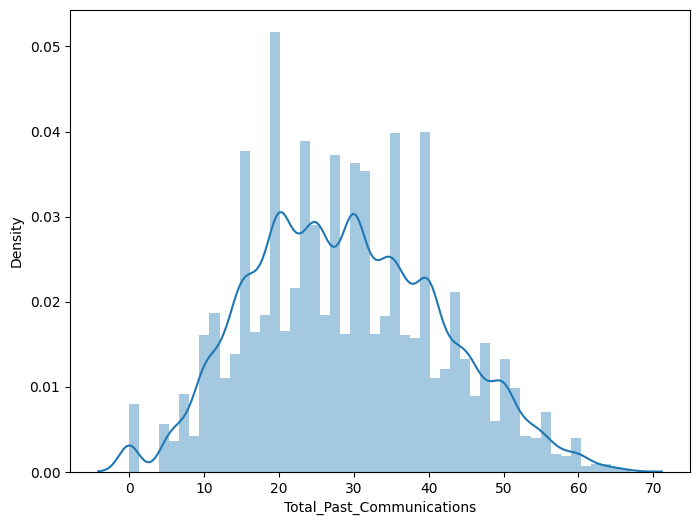

In [17]:
# Dense plot for Total_Past_Communications 
dense_plot(df,'Total_Past_Communications')

Since there is a large number of missing observation so let check their relation with some important features 

<Axes: xlabel='Total_Past_Communications', ylabel='Email_Source_Type'>

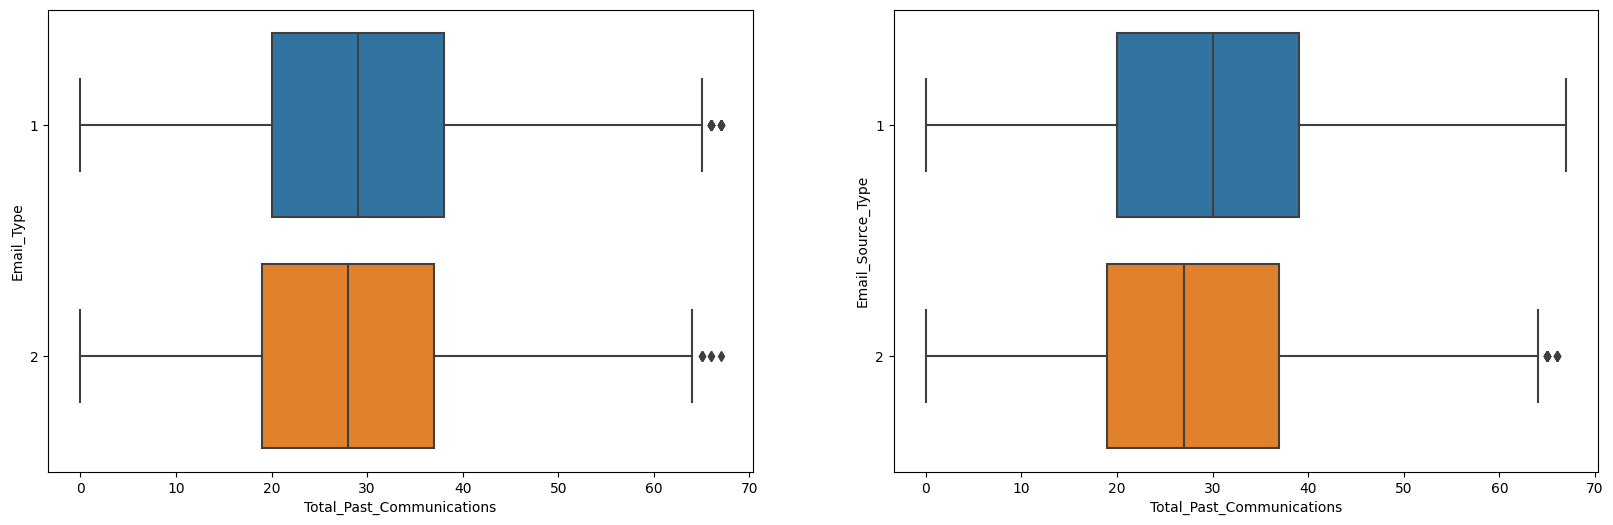

In [18]:
# Box plot to visualize Total_Past_Communications with Email_Type and Email_Source_Type
fig,axes= plt.subplots(1,2, figsize=(20,6))
sns.boxplot(ax=axes[0],data=df,x='Total_Past_Communications',y='Email_Type',orient='h')
sns.boxplot(ax=axes[1],data=df,x='Total_Past_Communications',y='Email_Source_Type',orient='h')

Number of outliers : 27
Outlier Percentage : 0.04%


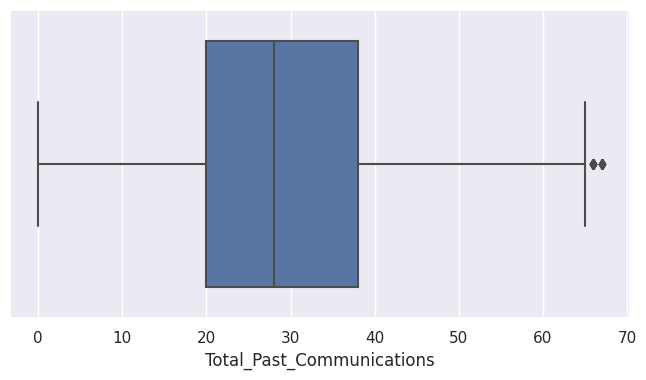

In [19]:
# lets get a box to know the outliers Total_Past_Communications and to get the count and percentage of the box plot 

out_count,out_percent=out_count_percen(df,'Total_Past_Communications')
print(f'Number of outliers : {out_count}')
print(f'Outlier Percentage : {out_percent}%')
box_plot(df,'Total_Past_Communications')

As there is very less number of outliers we can impute them with mean

In [20]:
# Replacing the missing values with mean
df.Total_Past_Communications.fillna(value=df.Total_Past_Communications.mean(),inplace=True)

Lets create a dense plot to know the distribution of Total_Links

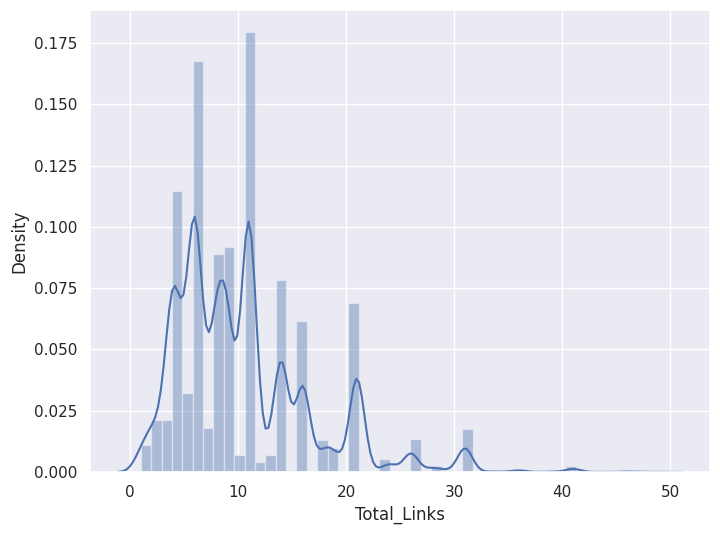

In [21]:
# Dense plot for Total_Links
dense_plot(df,'Total_Links')


Total_Links feature is positively skewed and has a very less number of missing 

Lets create a box to clearly understand the outliers

Number of outliers : 1608
Outlier Percentage : 2.35%


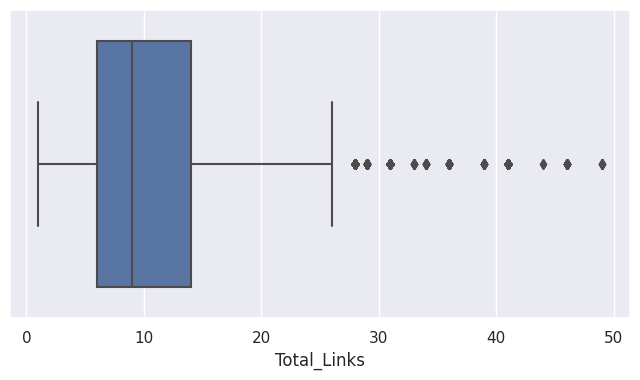

In [22]:
out_count,out_percent=out_count_percen(df,'Total_Links')
print(f'Number of outliers : {out_count}')
print(f'Outlier Percentage : {out_percent}%')
box_plot(df,'Total_Links')

We could see there is a notable number of outliers, So we impute the missing value with mode

In [23]:
# Filling the missing values with mode of Total_Links
df.Total_Links.fillna(value=df.Total_Links.mode()[0],inplace= True)

Lets create a dense plot to know the distribution of Total_Images

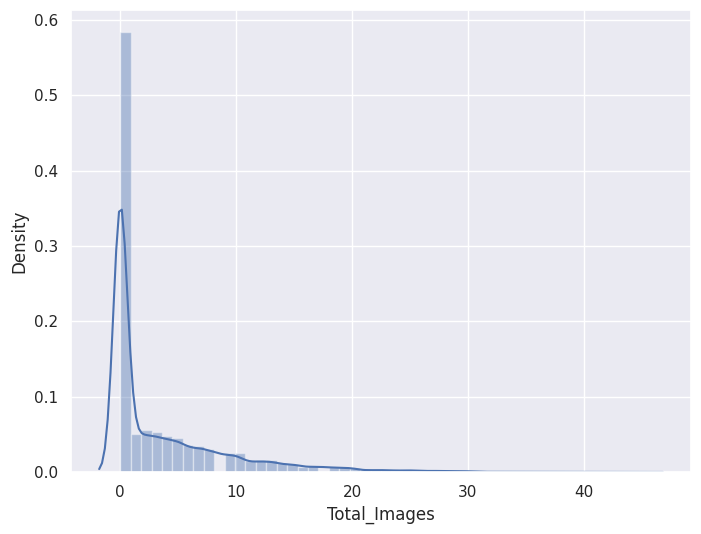

In [24]:
# Dense plot for Total_Images
dense_plot(df,'Total_Images')

Total_Images is positively skewed and has a less number of missing values 


Lets create a box plot to know more about the outliers 

Number of outliers : 5585
Outlier Percentage : 8.17%


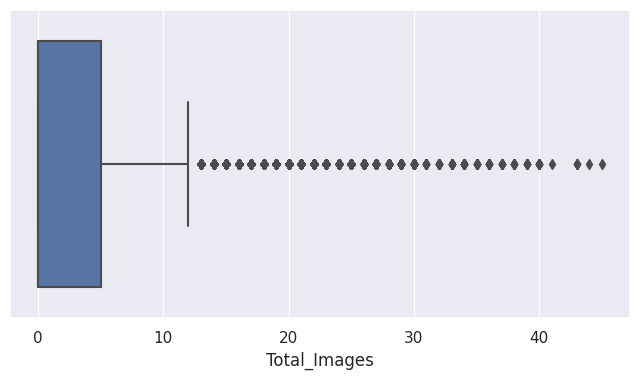

In [25]:
out_count,out_percent=out_count_percen(df,'Total_Images')
print(f'Number of outliers : {out_count}')
print(f'Outlier Percentage : {out_percent}%')
box_plot(df,'Total_Images')

As there is large values of outlies in Total_Images, So lets impute the missing values with mode 

In [26]:
# Filling the missing values with mode of Total_Images
df.Total_Images.fillna(value=df.Total_Images.mode()[0],inplace= True)

In [27]:
# Now lets see the number of number and percentage of missing values in the dataframe 
NA_count_percentage(df)


Customer_Location : 11595, 16.96%


## Data Type Conversion

In [28]:
# Data types of all feature in the dataframe 
df.dtypes

Email_ID                      object
Email_Type                     int64
Subject_Hotness_Score        float64
Email_Source_Type              int64
Customer_Location             object
Email_Campaign_Type            int64
Total_Past_Communications    float64
Time_Email_sent_Category       int64
Word_Count                     int64
Total_Links                  float64
Total_Images                 float64
Email_Status                   int64
dtype: object

Total_Past_Communications,Total_Links,Total_Images are of float data types so lets convert them to integer data types

In [29]:
df=df.astype({"Total_Past_Communications":int,'Total_Links' : int , 'Total_Images' : int})

# Exploratory Data Analysis


First and foremost lets check whether the data set is balanced or not

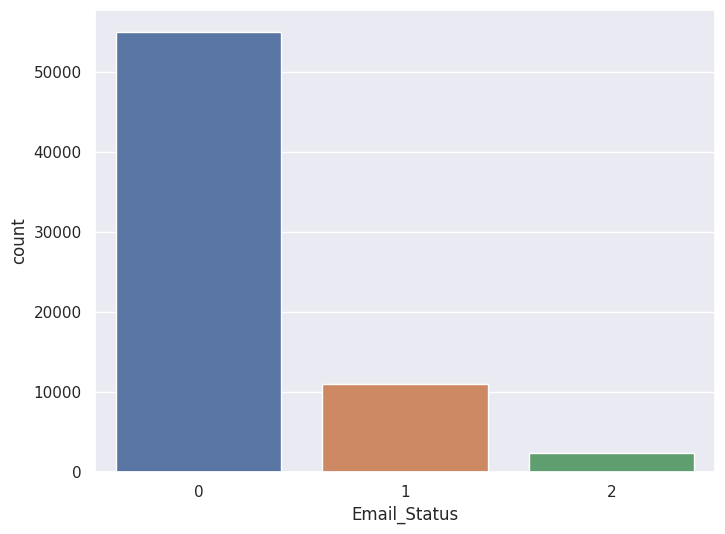

In [30]:
# Bar plot to show the count of each category in Email_Status
count_plot(df,'Email_Status')

Email_Status 0 has a very high obervations compared to other Email_Status 1 , 2 combined.

From this we come to know that the data set is highly imbalanced 

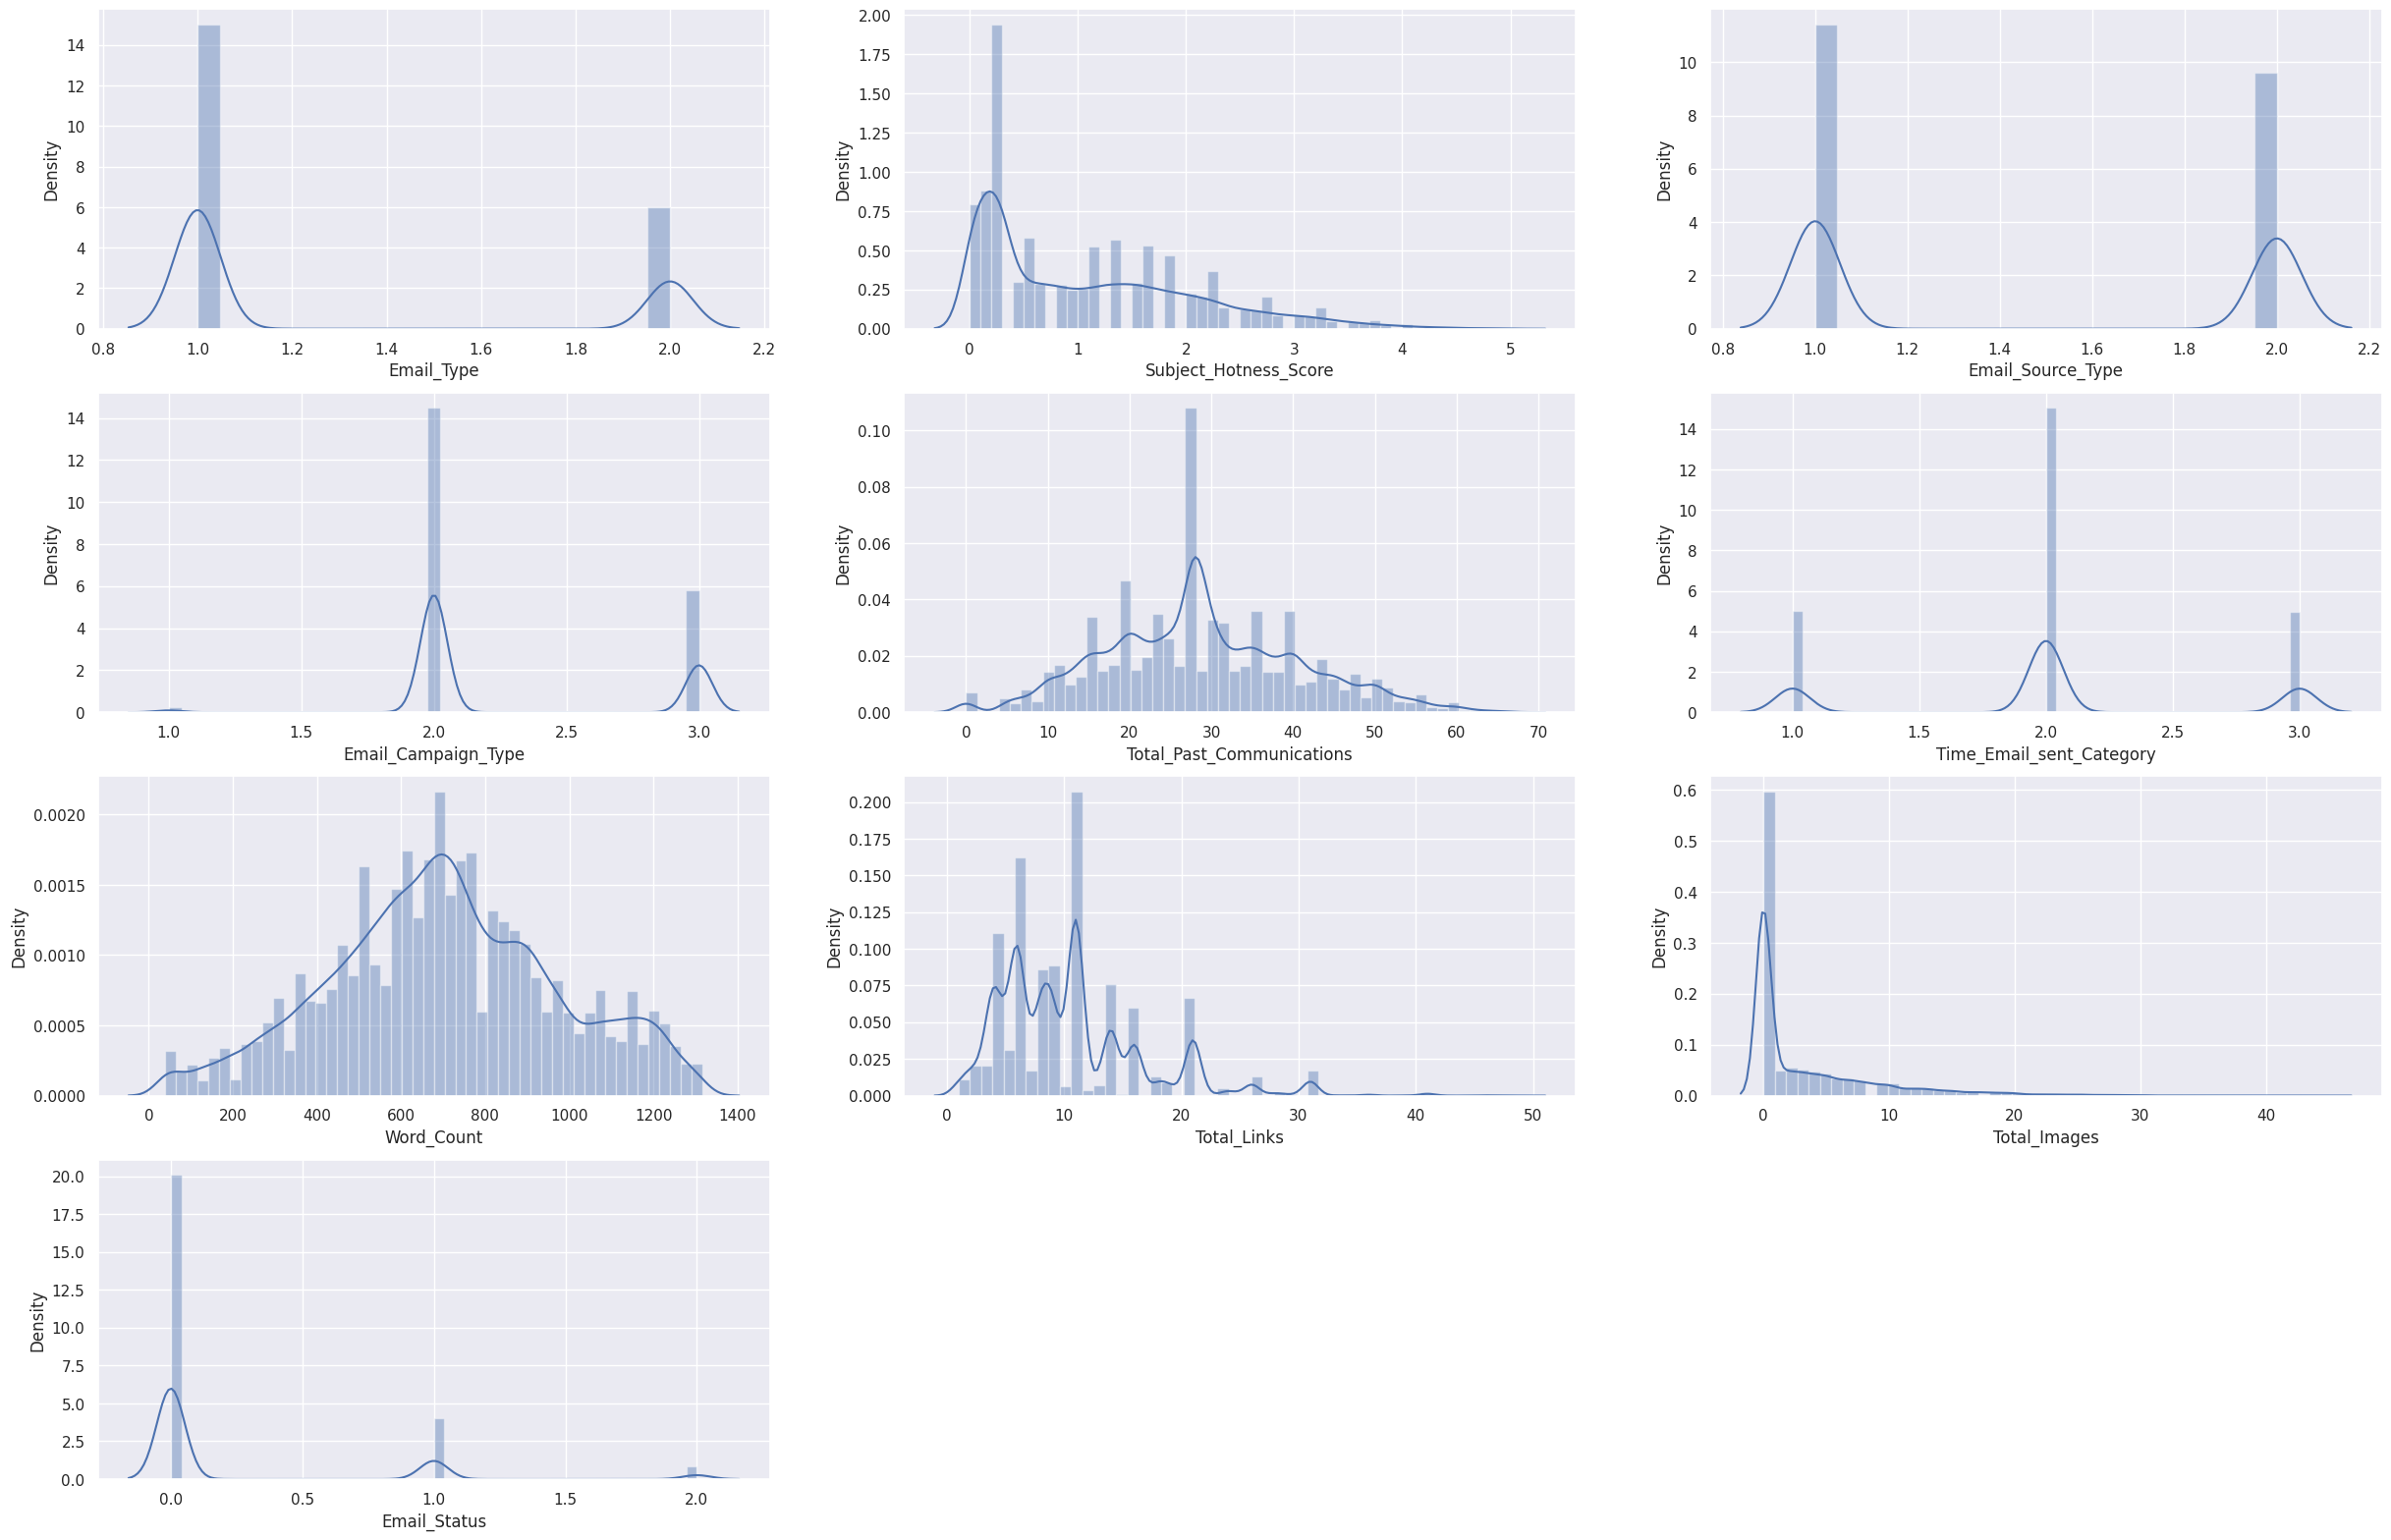

In [42]:
# Distribution plot for all features 
dist_plot_all_features(df)

Fetures like Subject_Hotness_Score, Total_Links and Total_Images are positively skewed and Total_Past_Communications and Word_Count are almost normally distributed. Rest of the features are categorical.

Lets check the impact of categorical on Email_Status  